In [138]:
%reload_ext autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import own scripts
import sys
sys.path.insert(0, '/src/')

%autoreload 2
from utils import plot_multi, norm_dist_test, Model

In [136]:
# load data
GDPC1 = pd.read_csv('data/GDPC1.csv')

## EDA: GDP
---
> What's is the distribution of change in GDP? Over 1 period and over 2 periods?

In [3]:
# converting dates from `str` to `time series`
gdp = pd.DataFrame()
gdp['Date'] = pd.to_datetime(GDPC1['DATE'], infer_datetime_format=True)
gdp['GDP'] = GDPC1['GDPC1']
gdp.set_index('Date', inplace=True, drop=True)
gdp.head()

,GDP
Date,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017


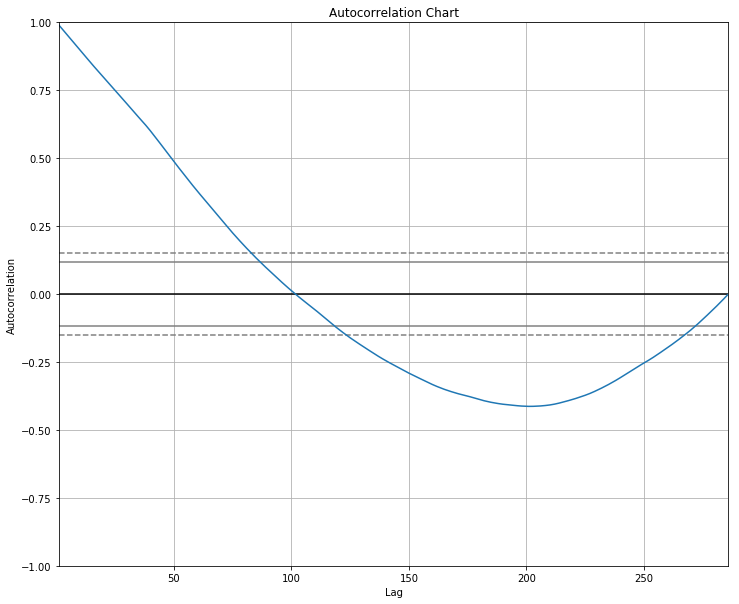

In [4]:
from pandas.plotting import autocorrelation_plot
series = gdp['GDP']
plt.figure(figsize=(12,10))
autocorrelation_plot(series)
plt.title('Autocorrelation Chart')
plt.show()

In [5]:
from pandas.core import datetools
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(15,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                 D2.GDP   No. Observations:                  284
Model:                ARIMA(15, 2, 2)   Log Likelihood               -1556.249
Method:                       css-mle   S.D. of innovations             57.424
Date:                Tue, 11 Sep 2018   AIC                           3150.497
Time:                        11:24:28   BIC                           3219.828
Sample:                    07-01-1947   HQIC                          3178.294
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2740      0.066      4.136      0.000       0.144       0.404
ar.L1.D2.GDP     -0.6697      0.074     -9.098      0.000      -0.814      -0.525
ar.L2.D2.GDP      0.4766      0.073     

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


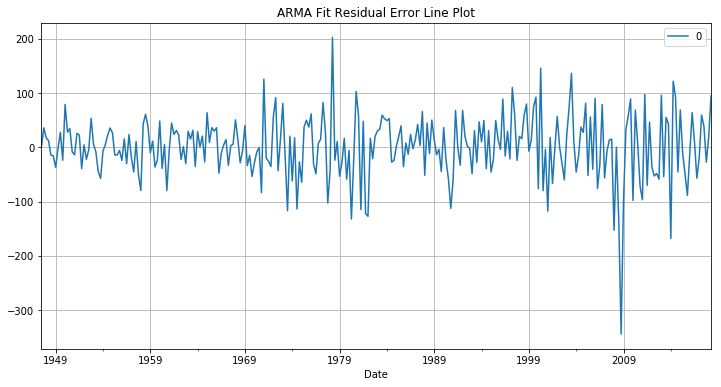

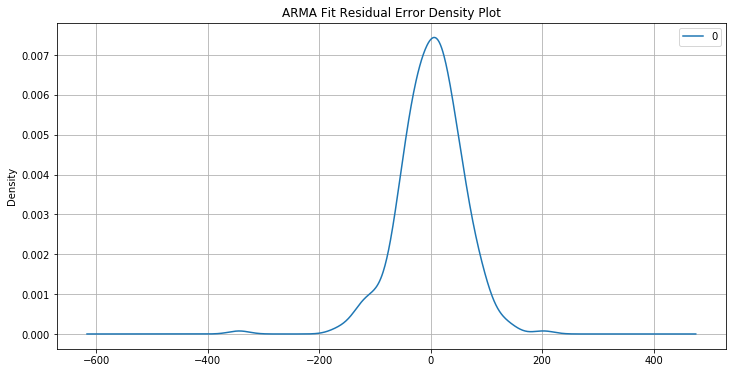

                0
count  284.000000
mean     0.573648
std     57.780882
min   -343.795837
25%    -30.363924
50%      2.656145
75%     36.027925
max    202.517604


In [6]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,6), grid=True)
plt.title('ARMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde', figsize=(12,6), grid=True)
plt.title('ARMA Fit Residual Error Density Plot')
plt.show()
print(residuals.describe())

In [45]:
from sklearn.metrics import mean_squared_error
X = series.values
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, observed=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Test MSE: 5261.847


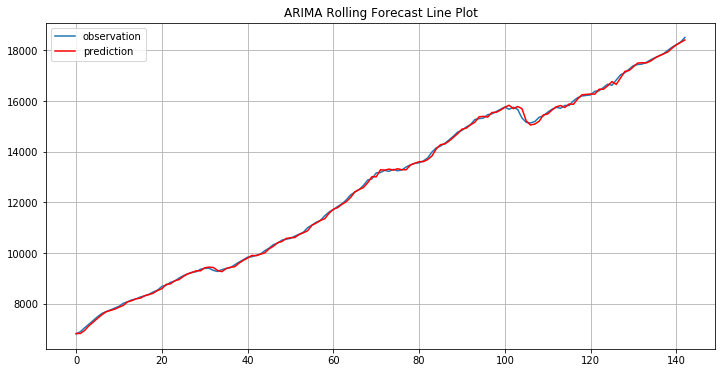

In [46]:
# plot
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('ARIMA Rolling Forecast Line Plot')
plt.grid()
plt.legend(['observation','prediction'])
plt.show()

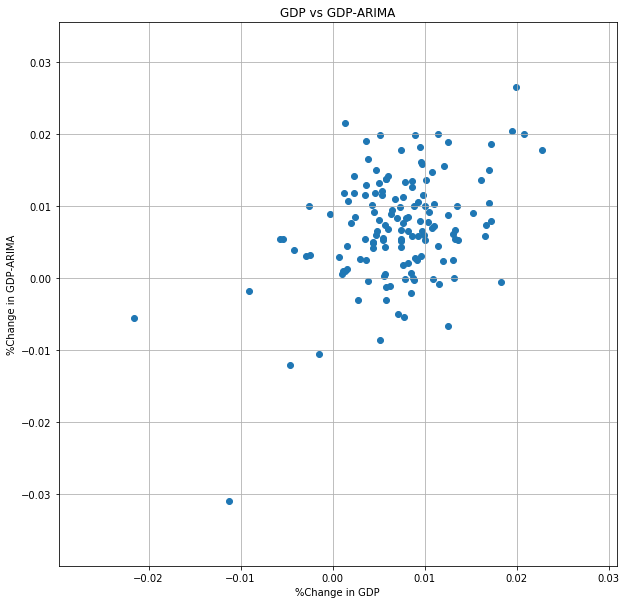

In [47]:
gdp1 = pd.DataFrame()
gdp1['Date'] = gdp.index[(gdp.shape[0] - len(predictions)):]
gdp1['gdp'], gdp1['gdp-ARIMA']  = test, [i[0] for i in predictions]

# add % changes
gdp1['%Chng-GDP'] = gdp1['gdp'].pct_change(periods=1)
gdp1['%Chng-GDP-ARIMA'] = gdp1['gdp-ARIMA'].pct_change(periods=1)

# plot
plt.figure(figsize=(10,10))
plt.scatter(gdp1['%Chng-GDP'], gdp1['%Chng-GDP-ARIMA'])
plt.grid()
plt.xlabel('%Change in GDP')
plt.ylabel('%Change in GDP-ARIMA')
plt.title('GDP vs GDP-ARIMA')
plt.show()

In [48]:
gdp1.head()
gdp1.to_csv('data/eda_gdp.csv', sep=',')

In [49]:
gdp1.head()

,Date,gdp,gdp-ARIMA,%Chng-GDP,%Chng-GDP-ARIMA
0,1982-10-01,6802.497,6822.242236,NaN,NaN
1,1983-01-01,6892.144,6822.869207,0.013179,0.000092
2,1983-04-01,7048.982,6944.153536,0.022756,0.017776
3,1983-07-01,7189.896,7128.861698,0.019991,0.026599
4,1983-10-01,7339.893,7271.379203,0.020862,0.019992


## EDA: FedFunds Rate
---
> What's the relevant date range? `1954-10-01` - `2018-04-01` <br>
> What's the relationship between `FedFunds` & `GDP`? <br>
> Is `FedFunds` rate a reliable leading indicator? <br>
> Does the distribution of change in GDP change when accounting for `FedFunds`?

In [50]:
# load data
FedFunds = pd.read_csv('data/FEDFUNDS.csv')

# clean up data
ff = pd.DataFrame()
ff['Date'] = pd.to_datetime(FedFunds['DATE'], infer_datetime_format=True)
ff['FedFunds'] = FedFunds['FEDFUNDS']
ff.head()

,Date,FedFunds
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.06
3,1954-10-01,0.85
4,1954-11-01,0.83


In [51]:
# add columns for the prev 1 months
ff['FedFunds1P'] = pd.Series([np.nan] + list(FedFunds['FEDFUNDS'].iloc[:-1]))

# compute change for the last 6 months
ff['%Chng6Mo'] = ff['FedFunds1P'].pct_change(periods=6)

ff.head()

,Date,FedFunds,FedFunds1P,%Chng6Mo
0,1954-07-01,0.80,NaN,NaN
1,1954-08-01,1.22,0.80,NaN
2,1954-09-01,1.06,1.22,NaN
3,1954-10-01,0.85,1.06,NaN
4,1954-11-01,0.83,0.85,NaN


In [52]:
# merge DFs on `Date`
gdp2 = pd.merge(gdp1[['Date', 'gdp', '%Chng-GDP', '%Chng-GDP-ARIMA']], 
                ff[['Date', 'FedFunds','FedFunds1P', '%Chng6Mo']], 
                left_on = 'Date', right_on = 'Date')

# dropna on rows
gdp2.dropna(axis=0, inplace=True)
gdp2

gdp2.head()

,Date,gdp,%Chng-GDP,%Chng-GDP-ARIMA,FedFunds,FedFunds1P,%Chng6Mo
1,1983-01-01,6892.144,0.013179,0.000092,8.68,8.95,-0.367491
2,1983-04-01,7048.982,0.022756,0.017776,8.80,8.77,-0.149370
3,1983-07-01,7189.896,0.019991,0.026599,9.37,8.98,0.003352
4,1983-10-01,7339.893,0.020862,0.019992,9.48,9.45,0.077537
5,1984-01-01,7483.371,0.019548,0.020433,9.56,9.47,0.054566


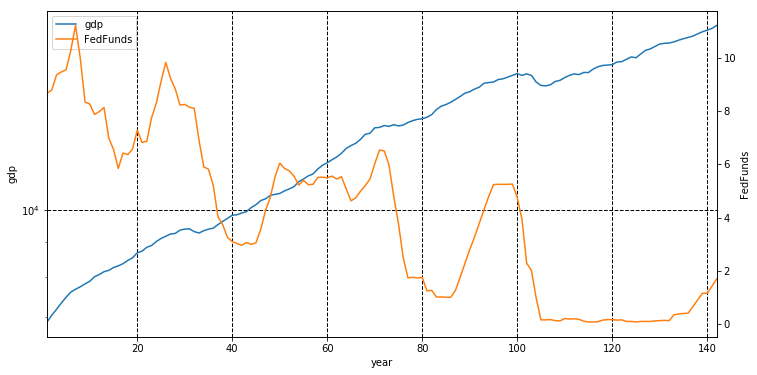

In [53]:
# FedFund log
plot_multi(gdp2[['gdp','FedFunds']], 'year', figsize=(12,6), logy=True)
plt.show()

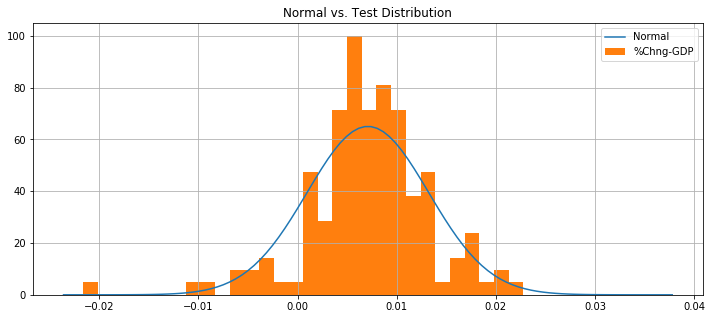

In [54]:
# is the `%Chng-GDP` rate normally distrubuted?
norm_dist_test(gdp2['%Chng-GDP'], '%Chng-GDP')

In [55]:
# build out the `label` columns on mean
gdp2['label'] = [1] * len(gdp2)
gdp_mean = np.mean(gdp2['%Chng-GDP'])
gdp2['label'].where(gdp2['%Chng-GDP'] > gdp_mean,0, inplace=True)
gdp2.drop(labels=['Date', 'gdp','%Chng-GDP','FedFunds'], axis=1, inplace=True)

gdp2.head()

,%Chng-GDP-ARIMA,FedFunds1P,%Chng6Mo,label
1,0.000092,8.95,-0.367491,1
2,0.017776,8.77,-0.149370,1
3,0.026599,8.98,0.003352,1
4,0.019992,9.45,0.077537,1
5,0.020433,9.47,0.054566,1


# Model: RandomForest
---

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [57]:
X = gdp2
y = X.pop('label')

[[ 7  2]
 [ 9 11]]


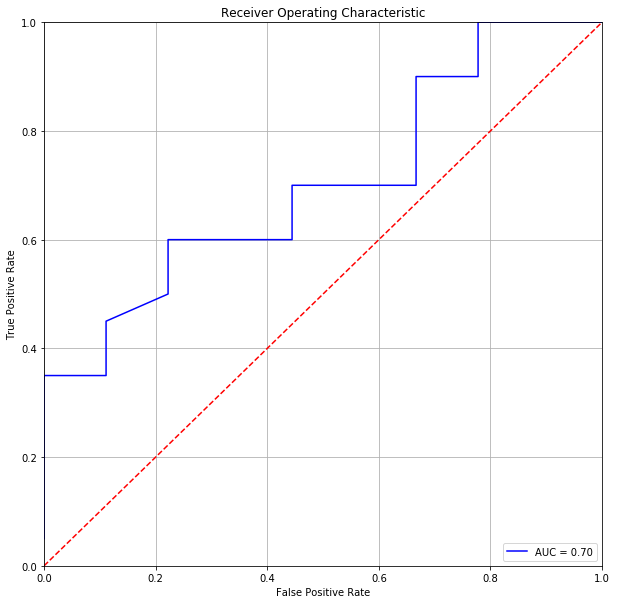

In [129]:
# model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
cf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=2)
cf.fit(X_train, y_train)
y_pred = cf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

y_prob = cf.predict_proba(X_test).T[1]
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()